# Datenanalyse: Anwendung des CAPM zur Bestimmung der erwartenden Renditen von Kryptowährungen

**Ausganglage**:<br> 
Kryptowährungen sind sehr volatil und damit risikoreich. Es können hohe Gewinne als auch hohe Verluste realisiert werden.

**Problemstellung**:<br> 
Wie kann mit Hilfe des CAPM bestimmt werden, welche Kryptowährungen unter Berücksichtigung des Risikos rentable sind?

**Zielsetzung**: Kaufempfehlung für Kryptowährungen unter Berücksichtigung der Rendite und Risiko

**Vorgehensweise**:<br>
1.	Daten werden aus verschiedenen Quellen zusammengeführt und geladen
2.	Relevante Daten werden extrahiert
3.	Daten werden in ein analysefähiges Dataframe transformiert
4.	Erwartete Renditen werden mit dem **CAPM** berechnet
5.	Risiken und Renditen der Kryptowährungen werden bestimmt
6.	Beispiel: Ermittlung von Rentenendwert mit erwarteten Renditen


## Capital-Asset-Pricing-Model (CAPM)

Um die erwartete Rendite einer Anlageklasse (Kryptowährungen oder Aktien) unter Berücksichtigung dessen Risiken zu berechnen, wird das CAPM verwendet.<br><br>

**Erwartete Rendite einer Kryptowährung = Rf + ß*(Rm - Rf)**<br><br>

**Rf** = Rendite eines risikolosen Investments (Bundesanleihen für 3 Jahre)<br>
**Rm** = Rendite aller Investments (oder geeigneter Referenzindex) = Marktrendite <br>
**ß** = Betafaktor = systematisches Risiko der Rendite<br>


### Bibliotheken 

In [2]:
import numpy as np 
seedNr = 7
np.random.seed(seedNr)

import datetime
import time

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
import cryptocompare

### Funktionen

In [3]:

#laedt Daten aus externen Quellen
def getCryptosClose(cryptos=['BTC'], column='close'):
    cryptoDic = {}
    index = []
    for cryptoName in cryptos:
        df = prepareData(cryptoName, 'EUR')
        if (df.empty == False) and (df[df.index.duplicated()].empty == True):
            cryptoDic[cryptoName] = df[column]
            index = df.index
        
    df2 = pd.DataFrame(cryptoDic, index=index)
    return df2
    

#bereitet die geladenen Daten zur Analyse
def prepareData(cryptoName='BTC', FIAT='EUR'):
    btcHist = cryptocompare.get_historical_price_day(cryptoName, curr=FIAT, limit=2000)
    df_btc = pd.DataFrame(btcHist) 

    df_btc['time'] = [pd.to_datetime(dt, unit='s').date() for dt in df_btc['time']]
    df_btc.set_index('time', inplace=True)

    return df_btc
    
    
#Berechnet den Beta-Wert
def beta_marketReturnRate_calc(cryptoSymbol):
    mR_crypto = df_cryptos_monthly_close_returns[['Rm', cryptoSymbol]]
    #
    var_mR_crypto = mR_crypto.var()
    cov_mR_crypto = mR_crypto.cov()
    Rm = mR_crypto.mean().loc['Rm']#
    #
    cov_crpto_Rm = cov_mR_crypto.loc['Rm',cryptoSymbol]
    var_Rm = var_mR_crypto.loc['Rm']
    #
    #Beta
    beta = (cov_crpto_Rm/var_Rm)
    #print('Beta = ß:', beta)
    return pd.DataFrame(data=[[beta], [Rm]], columns=[cryptoSymbol], index=['beta', 'Rm'])


#Rentenrechner
def pension_calc(pension, years, months, interest):
    ikon = ((1+interest)**(1./float(months)))-1
    nm = years*months
    #
    res = pension * (((ikon+1)**nm)-1) / ikon # Rentenformel
    return res

In [4]:

coinmarketcap_supported_coins = pd.read_html('https://coinmarketcap.com/all/views/all/')
bp_names_symbols = coinmarketcap_supported_coins[2].iloc[:,1:3]
bp_names_symbols


,Name,Symbol
0,Bitcoin,BTC
1,Ethereum,ETH
2,Cardano,ADA
3,Binance Coin,BNB
4,Tether,USDT
...,...,...
195,LTO Network,LTO
196,Aidos Kuneen,ADK
197,Akropolis,AKRO
198,Uquid Coin,UQC


### Datenbeschaffung

#### Bitpanda Crypto Index
Bitpanda ist eine Anbieter, der das Handeln von Kryptowährungen ermöglicht. Dieser bietet einen Kryptoindex an, der als Datenbasis fungiert. 

In [5]:
bci = pd.Series(name='bci', data=['BTC', 'DOT', 'ETH', 'BNB', 'LTC', 'MIOTA', 'TRX', 'UNI', 'LINK', 'BCH','EOS','NEO', 'XTZ', 'XMR', 'HT', 'ADA', 'DASH', 'XLM', 'DOGE', 'VET', 'AAVE', 'ATOM', 'XEM', 'BSV', 'THETA'])
print(bci.T)

0       BTC
1       DOT
2       ETH
3       BNB
4       LTC
5     MIOTA
6       TRX
7       UNI
8      LINK
9       BCH
10      EOS
11      NEO
12      XTZ
13      XMR
14       HT
15      ADA
16     DASH
17      XLM
18     DOGE
19      VET
20     AAVE
21     ATOM
22      XEM
23      BSV
24    THETA
Name: bci, dtype: object


#### Schlusskurse (Close)
Die Schlusskurse der Kryptowährungen werden in ein Dataframe geladen.<br>
**Datenquelle**: 'cryptocompare'

In [6]:
#get symbols only
bp_symbols = bp_names_symbols.iloc[:,1]

##create plotLineChart
##It may take some time...
df_close_cryptos = getCryptosClose(bp_symbols, 'close')
#df_close_cryptos.plot.line()

display(df_close_cryptos)

,BTC,ETH,ADA,BNB,USDT,DOT,XRP,LTC,LINK,BCH,...,GAS,JST,AVA,GT,HNS,LTO,ADK,AKRO,UQC,PHA
time,,,,,,,,,,,,,,,,,,,,,
2015-09-11,212.81,0.8625,0.000,0.00,0.0000,0.00,0.006638,2.611,0.00,0.00,...,0.000,0.00000,0.000,0.000,0.0000,0.0000,0.000,0.00000,0.000,0.0000
2015-09-12,209.31,0.9229,0.000,0.00,0.0000,0.00,0.006702,2.528,0.00,0.00,...,0.000,0.00000,0.000,0.000,0.0000,0.0000,0.000,0.00000,0.000,0.0000
2015-09-13,203.40,0.8381,0.000,0.00,0.0000,0.00,0.006692,2.465,0.00,0.00,...,0.000,0.00000,0.000,0.000,0.0000,0.0000,0.000,0.00000,0.000,0.0000
2015-09-14,204.14,0.7842,0.000,0.00,0.0000,0.00,0.006447,2.515,0.00,0.00,...,0.000,0.00000,0.000,0.000,0.0000,0.0000,0.000,0.00000,0.000,0.0000
2015-09-15,204.70,0.8365,0.000,0.00,0.0000,0.00,0.006614,2.503,0.00,0.00,...,0.000,0.00000,0.000,0.000,0.0000,0.0000,0.000,0.00000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27,38368.96,1213.2300,1.097,187.51,0.8319,27.81,0.362800,143.000,21.77,402.11,...,8.417,0.04039,2.171,1.188,0.2686,0.2532,2.971,0.02625,6.093,0.4703
2021-02-28,37409.89,1175.4200,1.087,174.03,0.8285,27.99,0.344200,136.850,20.40,381.21,...,10.010,0.03702,2.065,1.045,0.2555,0.2533,3.139,0.02550,6.322,0.4638
2021-03-01,41222.38,1304.6900,1.077,211.72,0.8312,29.61,0.370200,146.170,23.01,416.35,...,10.190,0.04002,2.184,1.124,0.2655,0.3083,3.435,0.02799,7.981,0.6206


#### Rohdaten-Überblick
Wichtige statistische Werte werden angezeigt um den Überblick über die Daten zu erhalten.

In [7]:
df_close_cryptos.describe()

,BTC,ETH,ADA,BNB,USDT,DOT,XRP,LTC,LINK,BCH,...,GAS,JST,AVA,GT,HNS,LTO,ADK,AKRO,UQC,PHA
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,...,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,5902.349925,224.782360,0.074633,11.174519,0.900884,0.810425,0.232944,49.133075,2.100185,288.563988,...,4.417592,0.003040,0.142752,0.127658,0.023030,0.024588,2.251265,0.002363,0.702558,0.013703
std,6450.522897,258.564555,0.135113,20.275493,5.789567,3.438967,0.250712,46.737372,4.331261,386.090172,...,8.579342,0.009746,0.343748,0.226516,0.052681,0.047092,4.730274,0.006022,1.390165,0.059482
min,202.460000,0.382800,0.000000,0.000000,0.000000,0.000000,0.003848,2.465000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,883.130000,12.270000,0.000000,0.000000,0.815500,0.000000,0.007270,3.801000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5472.470000,168.760000,0.037320,8.269000,0.858600,0.000000,0.207600,41.330000,0.295800,208.890000,...,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.262900,0.000000,0.073900,0.000000
75%,8176.910000,289.610000,0.082060,15.760000,0.896600,0.000000,0.289900,66.030000,2.049000,369.750000,...,2.815000,0.000000,0.099540,0.345500,0.000000,0.039470,2.022000,0.001368,0.793500,0.000000
max,47414.790000,1613.810000,1.097000,274.810000,191.930000,32.630000,2.290000,299.700000,28.630000,3162.250000,...,71.550000,0.065480,2.632000,1.998000,0.377300,0.329600,26.990000,0.048270,10.320000,0.675300


#### Null-Werte
Null- bzw. fehlende Werte beeinflussen Datenanalysen, daher wird überprüft, ob die Rohdaten Welche besitzen.

In [8]:
#check if null values exist
display(df_close_cryptos.isnull().sum())

BTC     0
ETH     0
ADA     0
BNB     0
USDT    0
       ..
LTO     0
ADK     0
AKRO    0
UQC     0
PHA     0
Length: 189, dtype: int64

#### Ueberpruefung der "infinite" Werte
DataFrames arbeiten nicht mit "infinite" Werten. Deswegen wird überprüft, ob diese im Dataframe vorkommen.

In [9]:
np.isinf(df_close_cryptos).values.sum() 

0

#### Standardisierung
Die Werte des Dataframes werden für die grafische Darstellung standardisiert.<br>
Aus Übersichtlichkeitsgründen werden nur 5 Kryptos angezeigt.

<AxesSubplot:xlabel='time'>

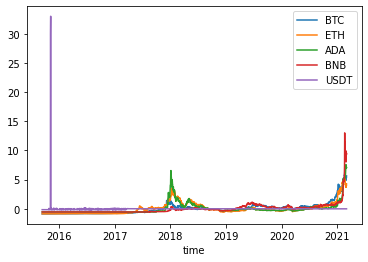

In [10]:
stdc = StandardScaler()

dfcc = df_close_cryptos.iloc[:,:5]
X_train_std = stdc.fit_transform(dfcc)

columns = dfcc.columns
index = dfcc.index

X_train_std_df = pd.DataFrame(X_train_std) 
X_train_std_df.columns = columns
X_train_std_df.index = index

X_train_std_df.plot.line()

### Renditeermittlung aller Kryptowährungen

In [11]:
#df_cryptos_daily_close = df_close_cryptos.copy()
df_cryptos_daily_close = df_close_cryptos.loc[:,bci].copy()
#
df_cryptos_daily_close.index = pd.to_datetime(df_cryptos_daily_close.index)
#df_cryptos_daily_close = df_cryptos_daily_close.drop(['WBTC', 'LUNA', 'STX'], axis=1)
df_cryptos_daily_close

,BTC,DOT,ETH,BNB,LTC,MIOTA,TRX,UNI,LINK,BCH,...,ADA,DASH,XLM,DOGE,VET,AAVE,ATOM,XEM,BSV,THETA
time,,,,,,,,,,,,,,,,,,,,,
2015-09-11,212.81,0.00,0.8625,0.00,2.611,0.0000,0.00000,0.00,0.00,0.00,...,0.000,2.128,0.001907,0.000117,0.00000,0.00,0.00,0.000083,0.00,0.000
2015-09-12,209.31,0.00,0.9229,0.00,2.528,0.0000,0.00000,0.00,0.00,0.00,...,0.000,2.173,0.001890,0.000150,0.00000,0.00,0.00,0.000077,0.00,0.000
2015-09-13,203.40,0.00,0.8381,0.00,2.465,0.0000,0.00000,0.00,0.00,0.00,...,0.000,2.040,0.001900,0.000111,0.00000,0.00,0.00,0.000079,0.00,0.000
2015-09-14,204.14,0.00,0.7842,0.00,2.515,0.0000,0.00000,0.00,0.00,0.00,...,0.000,2.038,0.001835,0.000110,0.00000,0.00,0.00,0.000080,0.00,0.000
2015-09-15,204.70,0.00,0.8365,0.00,2.503,0.0000,0.00000,0.00,0.00,0.00,...,0.000,2.061,0.001781,0.000138,0.00000,0.00,0.00,0.000088,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27,38368.96,27.81,1213.2300,187.51,143.000,0.9586,0.03879,19.58,21.77,402.11,...,1.097,175.350,0.364500,0.041650,0.03393,276.91,15.89,0.483100,153.44,2.623
2021-02-28,37409.89,27.99,1175.4200,174.03,136.850,0.9307,0.03771,18.40,20.40,381.21,...,1.087,163.140,0.335700,0.039860,0.03293,293.44,14.61,0.525000,147.02,2.596
2021-03-01,41222.38,29.61,1304.6900,211.72,146.170,0.9998,0.03975,21.33,23.01,416.35,...,1.077,186.280,0.357300,0.042030,0.03795,320.09,15.54,0.555000,154.25,2.730


#### Tägliche Rendite-Werte

In [12]:
#daily
df_cryptos_daily_close_returns = df_cryptos_daily_close.pct_change()
df_cryptos_daily_close_returns

,BTC,DOT,ETH,BNB,LTC,MIOTA,TRX,UNI,LINK,BCH,...,ADA,DASH,XLM,DOGE,VET,AAVE,ATOM,XEM,BSV,THETA
time,,,,,,,,,,,,,,,,,,,,,
2015-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-12,-0.016447,NaN,0.070029,NaN,-0.031789,NaN,NaN,NaN,NaN,NaN,...,NaN,0.021147,-0.008915,0.281197,NaN,NaN,NaN,-0.066988,NaN,NaN
2015-09-13,-0.028236,NaN,-0.091884,NaN,-0.024921,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.061206,0.005291,-0.262842,NaN,NaN,NaN,0.024406,NaN,NaN
2015-09-14,0.003638,NaN,-0.064312,NaN,0.020284,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.000980,-0.034211,-0.004525,NaN,NaN,NaN,0.003530,NaN,NaN
2015-09-15,0.002743,NaN,0.066692,NaN,-0.004771,NaN,NaN,NaN,NaN,NaN,...,NaN,0.011286,-0.029428,0.254545,NaN,NaN,NaN,0.105640,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27,-0.002403,0.070439,0.011354,0.018633,0.011172,0.039020,0.033849,0.019792,0.043124,-0.000497,...,0.061955,0.022449,0.096900,-0.005017,0.034136,0.032360,0.018590,0.131912,0.023479,0.033898
2021-02-28,-0.024996,0.006472,-0.031165,-0.071889,-0.043007,-0.029105,-0.027842,-0.060266,-0.062931,-0.051976,...,-0.009116,-0.069632,-0.079012,-0.042977,-0.029472,0.059694,-0.080554,0.086732,-0.041840,-0.010294
2021-03-01,0.101911,0.057878,0.109978,0.216572,0.068104,0.074245,0.054097,0.159239,0.127941,0.092180,...,-0.009200,0.141841,0.064343,0.054441,0.152445,0.090819,0.063655,0.057143,0.049177,0.051618


#### Monatliche Rendite-Werte

In [13]:
#monthly
df_cryptos_monthly_close_returns = df_cryptos_daily_close.resample('M').last().ffill().pct_change()
df_cryptos_monthly_close_returns = df_cryptos_monthly_close_returns.iloc[1:,:]
df_cryptos_monthly_close_returns

,BTC,DOT,ETH,BNB,LTC,MIOTA,TRX,UNI,LINK,BCH,...,ADA,DASH,XLM,DOGE,VET,AAVE,ATOM,XEM,BSV,THETA
time,,,,,,,,,,,,,,,,,,,,,
2015-10-31,0.337549,NaN,0.214698,NaN,0.220818,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.030158,0.152161,-0.082500,NaN,NaN,NaN,-0.002256,NaN,NaN
2015-11-30,0.264828,NaN,0.037375,NaN,0.037150,NaN,NaN,NaN,NaN,NaN,...,NaN,0.012833,-1.000000,0.044505,NaN,NaN,NaN,-0.246420,NaN,NaN
2015-12-31,0.111254,NaN,0.028558,NaN,-0.055784,NaN,NaN,NaN,NaN,NaN,...,NaN,0.501949,inf,0.256522,NaN,NaN,NaN,0.469000,NaN,NaN
2016-01-31,-0.135235,NaN,1.555061,NaN,-0.120958,NaN,NaN,NaN,NaN,NaN,...,NaN,0.238482,-1.000000,2.017301,NaN,NaN,NaN,2.084411,NaN,NaN
2016-02-29,0.160316,NaN,1.629069,NaN,0.103643,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.070474,inf,-0.449541,NaN,NaN,NaN,0.309865,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30,0.386514,0.248608,0.548341,0.073151,0.527151,0.365057,0.218863,0.617556,0.232891,0.176345,...,0.795770,0.565470,1.532614,0.341663,0.572001,1.487270,0.173354,0.961423,0.077222,0.024218
2020-12-31,0.441646,0.688963,0.172579,0.164128,0.391138,-0.184574,-0.188449,0.340209,-0.226325,0.057071,...,0.032753,-0.136185,-0.380699,0.290891,0.153673,0.138740,0.137419,0.081131,-0.124500,1.843046
2021-01-31,0.155068,0.757096,0.799535,0.197906,0.051022,0.383726,0.191606,2.464362,1.027394,0.179512,...,0.926451,0.038462,1.420650,6.956453,0.362573,2.427880,0.271696,0.093235,0.074021,0.035363


### Ermittlung der Marktrendite
Nur Kryptowährungen, die seit 2008 existierten, werden bei der Ermittlung der Marktrendite berücksichtigt.

In [14]:
start_DATE = '2018-02-01'
end_DATE = '2021-02-28'

a = df_cryptos_monthly_close_returns.index >= pd.to_datetime(start_DATE)
b = df_cryptos_monthly_close_returns.index <= pd.to_datetime(end_DATE)
mask = (a) & (b) 

df_cryptos_monthly_close_returns = df_cryptos_monthly_close_returns.loc[mask].dropna(axis=1)
df_cryptos_monthly_close_returns = df_cryptos_monthly_close_returns.replace([np.inf, -np.inf], np.nan).dropna()

Rm_value = df_cryptos_monthly_close_returns.mean(axis=1)
df_cryptos_monthly_close_returns.insert(0,'Rm',Rm_value) # Marktrendite
df_cryptos_monthly_close_returns

,Rm,BTC,ETH,BNB,LTC,MIOTA,TRX,LINK,BCH,EOS,...,XTZ,XMR,HT,ADA,DASH,XLM,DOGE,VET,XEM,THETA
time,,,,,,,,,,,,,,,,,,,,,
2018-03-31,-0.384089,-0.334439,-0.541765,0.047993,-0.430591,-0.422914,-0.094719,-0.579874,-0.434564,-0.281259,...,-0.341937,-0.378946,-0.207324,-0.501419,-0.481209,-0.390406,-0.542376,-0.480965,-0.453506,-0.207239
2018-04-30,0.821702,0.359763,0.732923,0.320228,0.301294,0.859077,1.794750,0.997353,1.011710,1.984981,...,0.322609,0.382565,0.652452,1.288618,0.585027,1.116223,0.924215,0.934917,0.898813,0.256105
2018-05-31,-0.121666,-0.161994,-0.107174,0.026227,-0.174548,-0.074074,-0.331985,-0.348498,-0.234984,-0.270440,...,0.377208,-0.333400,0.646022,-0.324334,-0.334837,-0.278318,-0.343044,-0.215163,-0.376898,0.772612
2018-06-30,-0.264115,-0.147269,-0.215437,0.032976,-0.313975,-0.423133,-0.368483,-0.342034,-0.249141,-0.336207,...,-0.092911,-0.160406,-0.148942,-0.381703,-0.218471,-0.344035,-0.236963,-0.245578,-0.334448,-0.337148
2018-07-31,-0.071619,0.211141,-0.048235,-0.055866,-0.029081,-0.059170,-0.107916,0.292633,0.035475,-0.095238,...,-0.557749,-0.066577,-0.193430,0.031463,-0.085810,0.425982,0.209670,-0.991168,-0.002872,-0.309209
2018-08-31,-0.161119,-0.087548,-0.343738,-0.201944,-0.207295,-0.248495,-0.242634,0.120765,-0.296089,-0.119617,...,-0.255730,-0.040648,-0.301485,-0.277494,-0.103411,-0.191102,0.596464,-0.251149,-0.348596,-0.103728
2018-09-30,-0.082970,-0.056336,-0.173673,-0.087173,-0.014403,-0.194998,-0.128604,0.017070,-0.019836,-0.110507,...,0.029984,-0.004497,-0.091553,-0.166134,-0.035176,0.169199,0.215214,-0.751193,-0.080239,-0.117592
2018-10-31,-0.024124,-0.018298,-0.128052,-0.033418,-0.167584,-0.151472,0.030462,0.570629,-0.180304,-0.063136,...,-0.099135,-0.073379,-0.200960,-0.151752,-0.164683,-0.109319,-0.325674,0.904932,0.004686,0.042270
2018-11-30,-0.404361,-0.368616,-0.430494,-0.463625,-0.357729,-0.391960,-0.352192,-0.368210,-0.596811,-0.447826,...,-0.619825,-0.446647,-0.287538,-0.453460,-0.400386,-0.295272,-0.442714,-0.641306,-0.217199,-0.006443


### Statistische Werte aller Krypto-Renditen

#### Einige von diesen Werten werden später in den Formeln benötigt und eingesetzt.

In [15]:
stats = df_cryptos_monthly_close_returns.describe()

corr = df_cryptos_monthly_close_returns.iloc[0:,1:].corr()
cov = df_cryptos_monthly_close_returns.cov()
var = df_cryptos_monthly_close_returns.var()

display(stats)

,Rm,BTC,ETH,BNB,LTC,MIOTA,TRX,LINK,BCH,EOS,...,XTZ,XMR,HT,ADA,DASH,XLM,DOGE,VET,XEM,THETA
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.088901,0.066450,0.064276,0.176325,0.031935,0.053071,0.057020,0.217855,0.024054,0.036229,...,0.065612,0.022261,0.100939,0.150724,0.032803,0.081606,0.235657,0.060485,0.098609,0.182689
std,0.318774,0.231076,0.331233,0.666375,0.284883,0.437426,0.388376,0.570758,0.341189,0.431681,...,0.414245,0.251425,0.358707,0.618481,0.433047,0.471871,1.190532,0.451340,0.516380,0.537803
min,-0.404361,-0.368616,-0.541765,-0.463625,-0.430591,-0.423133,-0.368483,-0.579874,-0.596811,-0.447826,...,-0.619825,-0.446647,-0.308999,-0.501419,-0.481209,-0.390406,-0.542376,-0.991168,-0.453506,-0.481816
25%,-0.108434,-0.081072,-0.168264,-0.092328,-0.171445,-0.235244,-0.176204,-0.197581,-0.179818,-0.189414,...,-0.163211,-0.118819,-0.154023,-0.176418,-0.218851,-0.242137,-0.148842,-0.246971,-0.191957,-0.183003
50%,-0.014704,-0.001892,0.060746,0.040484,-0.021742,-0.066622,-0.031439,0.103133,-0.079992,-0.088887,...,-0.004950,-0.036897,-0.028622,-0.033690,-0.094610,-0.058295,0.002958,0.032143,-0.017034,0.038817
75%,0.288194,0.247862,0.221448,0.261878,0.237746,0.222711,0.235941,0.521814,0.165424,0.169009,...,0.257593,0.168924,0.268690,0.351156,0.067707,0.305342,0.296721,0.383331,0.099391,0.313313
max,0.842412,0.625629,0.799535,3.752321,0.663673,1.778209,1.794750,2.245902,1.011710,1.984981,...,1.599275,0.632771,1.176638,2.807356,1.848253,1.532614,6.956453,0.934917,1.730109,1.843046


#### Korrelationsmatrix
Es wird eine Korrelationsmatrix erstellt, die für die Zusammenstellung eines Portfolios wichtig ist.  

In [16]:
display(corr.loc['DOGE','ADA'])#Die beiden Kryptos würden gut in einem Portfolio passen
display(corr)

0.3491449171071452

,BTC,ETH,BNB,LTC,MIOTA,TRX,LINK,BCH,EOS,NEO,XTZ,XMR,HT,ADA,DASH,XLM,DOGE,VET,XEM,THETA
BTC,1.000000,0.773853,0.431865,0.863109,0.635670,0.507397,0.552529,0.801044,0.609977,0.660719,0.275995,0.807685,0.429981,0.602155,0.655743,0.577664,0.250082,0.444947,0.573569,0.360045
ETH,0.773853,1.000000,0.255474,0.768084,0.635143,0.636930,0.625506,0.762167,0.717252,0.804483,0.461866,0.631124,0.503973,0.582212,0.594807,0.781465,0.535215,0.617057,0.570124,0.295457
BNB,0.431865,0.255474,1.000000,0.415713,0.789214,0.326651,0.095609,0.324538,0.287493,0.495298,0.282351,0.603809,0.641932,0.831501,0.527417,0.227449,0.081985,0.355385,0.638829,0.293232
LTC,0.863109,0.768084,0.415713,1.000000,0.642556,0.507388,0.464481,0.817843,0.657433,0.665728,0.413016,0.803006,0.487625,0.584586,0.793670,0.570483,0.177033,0.488091,0.580136,0.412240
MIOTA,0.635670,0.635143,0.789214,0.642556,1.000000,0.661591,0.339002,0.664242,0.647765,0.760530,0.322520,0.753197,0.620258,0.921680,0.804805,0.580281,0.272489,0.545679,0.786783,0.240989
TRX,0.507397,0.636930,0.326651,0.507388,0.661591,1.000000,0.511758,0.700318,0.862551,0.740453,0.228909,0.577001,0.408799,0.600170,0.559910,0.565285,0.215377,0.570903,0.604798,0.093560
LINK,0.552529,0.625506,0.095609,0.464481,0.339002,0.511758,1.000000,0.460256,0.430502,0.692724,0.166412,0.418744,0.342720,0.304261,0.382073,0.441490,0.342565,0.401972,0.414865,0.019901
BCH,0.801044,0.762167,0.324538,0.817843,0.664242,0.700318,0.460256,1.000000,0.860927,0.693598,0.417765,0.800013,0.498056,0.565648,0.771049,0.603088,0.261054,0.468802,0.506288,0.171170
EOS,0.609977,0.717252,0.287493,0.657433,0.647765,0.862551,0.430502,0.860927,1.000000,0.695911,0.378504,0.670709,0.475021,0.565969,0.650116,0.637002,0.222817,0.539666,0.532654,0.211358
NEO,0.660719,0.804483,0.495298,0.665728,0.760530,0.740453,0.692724,0.693598,0.695911,1.000000,0.418142,0.690514,0.600934,0.720223,0.648163,0.676655,0.430892,0.578556,0.772044,0.305655


### Ermittlung des Beta-Faktors
**ß** = Betafaktor = systematisches Risiko<br>
**cov_mR_crypto** = Kovarianz(Rendite einer Krypto; Varianz der Marktrendite)<br>
**var_Rm** = Varianz der Marktrendite<br>

**Beta-Faktor = cov_mR_crypto / var_Rm**

Ist **ß > 1**, dann schwankt die Krypto stärker als der Markt und ist instabil.<br>
Ist **ß < 1**, dann schwankt die Krypto weniger stark als der Markt.<br>
Ist **ß = 1**, dann bewegt sich die Krypto gleich dem Gesamtmarkt<br>
Ist **ß <= 0**, dann ist die Krypto nicht sensitiv gegenüber dem Krypto-Markt. Es könnte sich hier um Stable-Coins bspw. handeln.

In [17]:
selectedColumns = df_cryptos_monthly_close_returns.iloc[:,1:].columns#ohne die erste Spalte
beta_Rm_df = pd.DataFrame(index=['beta', 'Rm'])
#
for i,crpt_col in enumerate(selectedColumns):
    symbol_beta_Rm = beta_marketReturnRate_calc(crpt_col)
    beta_Rm_df.insert(i, symbol_beta_Rm.columns[0], symbol_beta_Rm.values)


#### Kryptos mit hoher Volatilität (Beta > 3)
Kryptowährungen deren Betawert höher als 3 beträgt.

In [18]:
m = (beta_Rm_df.iloc[0,:] > 3.)#Zeige alle Kryptos, die groesser als 3 sind
beta_Rm_df.T.loc[m].T

""
beta
Rm


#### Risikobegrenzung
Kryptowährungen deren Betawert höher als 3 beträgt, werden aus der zu bearbeitenden Krypto-Liste entfernt. 

In [19]:
m = (beta_Rm_df.iloc[0,:] <= 3.) 
beta_Rm_df = beta_Rm_df.T.loc[m].T

display(beta_Rm_df)#.loc['beta',:])

,BTC,ETH,BNB,LTC,MIOTA,TRX,LINK,BCH,EOS,NEO,XTZ,XMR,HT,ADA,DASH,XLM,DOGE,VET,XEM,THETA
beta,0.563653,0.897268,1.308403,0.703459,1.196327,0.890910,1.037919,0.848322,1.041721,0.946334,0.675893,0.623377,0.808098,1.676065,1.042074,1.132172,1.874237,0.938318,1.231009,0.564442
Rm,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901,0.088901


### Ermittlung der erwarteten Rendite einer Kryptowährung 
#### expectedCryptoReturn = Rf + ß*(Rm - Rf)

**Rf** = Rendite eines risikolosen Investments = Bundesanleihen für 3 Jahre<br>
**Rm** = Rendite aller Investments (oder geeigneter Referenzindex) = Marktrendite<br>
**ß = Betafaktor** = systematisches Risiko der Rendite

#### Risikolose Rendite wird ermittelt
Die US-Anleihe-Rendite-Historie (3 Monate) wird gelesen und in Monatswerte umgerechnet.<br>
Der monatlich berechnete Rendite-Verlauf wird grafisch veranschaulicht.


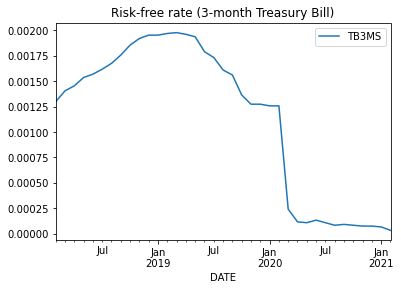

In [20]:
rf = web.DataReader('TB3MS', 'fred', start=start_DATE, end=end_DATE)
rf = (1 + (rf / 100)) ** (1 / 12) - 1
rf.plot(title='Risk-free rate (3-month Treasury Bill)')
#
#Rf = 0.043 #USA fuer 3 Monate
Rf = rf.tail(1)
Rf = Rf['TB3MS'][0]

#### Renditen und Betas

In [21]:
#
Rm = beta_Rm_df.iloc[1,0]# Durchschnittliche Markrendite
betas = beta_Rm_df.iloc[0,:]
#
expectedCryptoReturn = Rf + (betas*(Rm-Rf)) # Erwartete Rendite-Berechnung
#
expectedCryptoReturn.name = 'expectedReturn'
expectedCryptoReturn_beta = beta_Rm_df.append(expectedCryptoReturn)
expectedCryptoReturn_beta = expectedCryptoReturn_beta.drop('Rm')
expectedCryptoReturn_beta = expectedCryptoReturn_beta.reindex(['expectedReturn','beta'])
expectedCryptoReturn_beta = expectedCryptoReturn_beta.T.sort_values(by=['expectedReturn'], ascending=False).T




Kryptowährungen mit einer Rendite von weniger als 1% werden entfernt.

In [22]:
m = (expectedCryptoReturn_beta.loc['expectedReturn',:] < 0.01) 
display(expectedCryptoReturn_beta.T.loc[m].T)
#
m = (expectedCryptoReturn_beta.loc['expectedReturn',:] >= 0.01) 
expectedCryptoReturn_beta = expectedCryptoReturn_beta.T.loc[m].T

""
expectedReturn
beta


Hohe Renditen und Betas werden tabellerisch und grafisch dargestellt.

,DOGE,ADA,BNB,XEM,MIOTA,XLM,DASH,EOS,LINK,NEO,VET,ETH,TRX,BCH,HT,LTC,XTZ,XMR,THETA,BTC
expectedReturn,0.166593,0.148982,0.116308,0.109431,0.106348,0.100647,0.092640,0.092609,0.092271,0.084132,0.083420,0.079772,0.079207,0.075422,0.071847,0.062548,0.060099,0.055432,0.050194,0.050124
beta,1.874237,1.676065,1.308403,1.231009,1.196327,1.132172,1.042074,1.041721,1.037919,0.946334,0.938318,0.897268,0.890910,0.848322,0.808098,0.703459,0.675893,0.623377,0.564442,0.563653


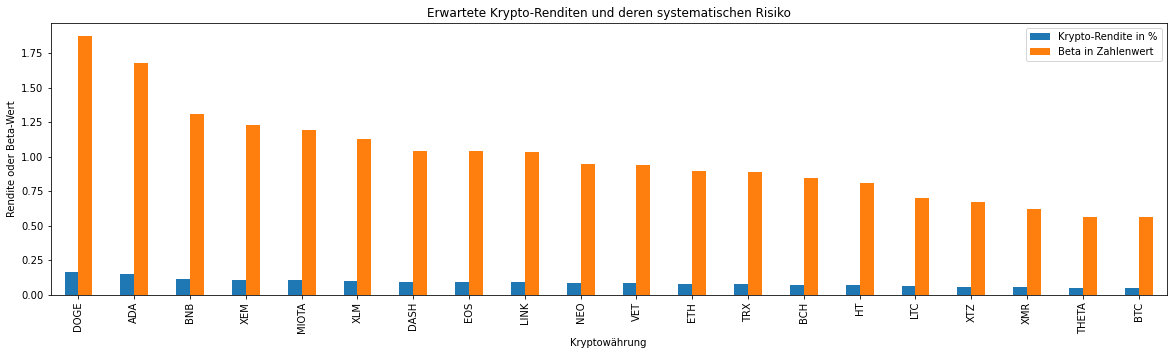

In [23]:
display(expectedCryptoReturn_beta)
#
ax = expectedCryptoReturn_beta.T.plot.bar(lw=2, figsize=(20,5), title='Erwartete Krypto-Renditen und deren systematischen Risiko')
ax.set_xlabel("Kryptowährung")
ax.set_ylabel("Rendite oder Beta-Wert")
ax.legend(["Krypto-Rendite in %", "Beta in Zahlenwert"]);

#### Alle gewinnbringenden Kryptowährungsrenditen
Sie sind absteigend von links nach rechts dargestellt.

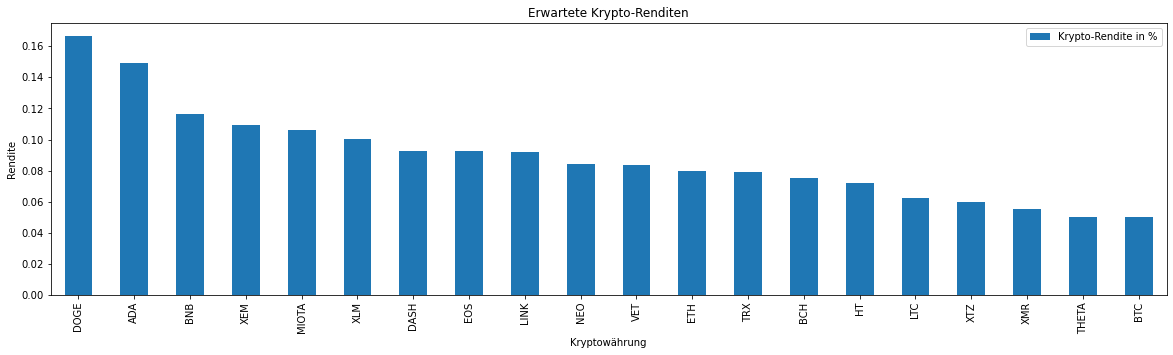

In [24]:
best_return = expectedCryptoReturn_beta.T['expectedReturn']

ax = best_return.plot.bar(lw=2, figsize=(20,5), title='Erwartete Krypto-Renditen')
ax.set_xlabel("Kryptowährung")
ax.set_ylabel("Rendite")
ax.legend(["Krypto-Rendite in %"]);
plt.savefig('erwarteteRenditenAlsBalkenDiagramm.jpg')

#### Bestimmung von unterbewertete Kryptowährungen
Vergleich der erzielten Rendite mit der Marktrendite<br>

##### Kreisdiagramm:
Anteil der Kryptos an der Gesamtrendite, die besser als der Markt abschnitten.

,expectedReturn,beta
DOGE,0.166593,1.874237
ADA,0.148982,1.676065
BNB,0.116308,1.308403
XEM,0.109431,1.231009
MIOTA,0.106348,1.196327
XLM,0.100647,1.132172
DASH,0.092640,1.042074
EOS,0.092609,1.041721
LINK,0.092271,1.037919


(9, 2)


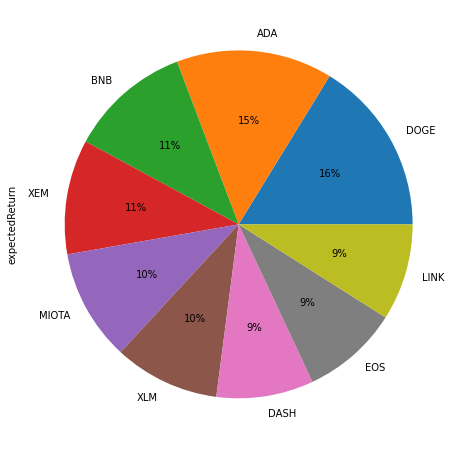

In [25]:
m = (expectedCryptoReturn_beta.iloc[0,:] >= Rm)
crpytos_to_buy = expectedCryptoReturn_beta.T[m]
display(crpytos_to_buy)
#
crpytos_to_buy['expectedReturn'].plot.pie(y='expectedReturn', figsize=(8, 8), autopct='%1.0f%%')
plt.savefig('erwarteteRenditenBesserAlsDerMarkt.jpg')
print(crpytos_to_buy.shape)

#### Risikoanalyse
Darstellung des Risikos der Kryptowährung aufsteigend von links nach rechts

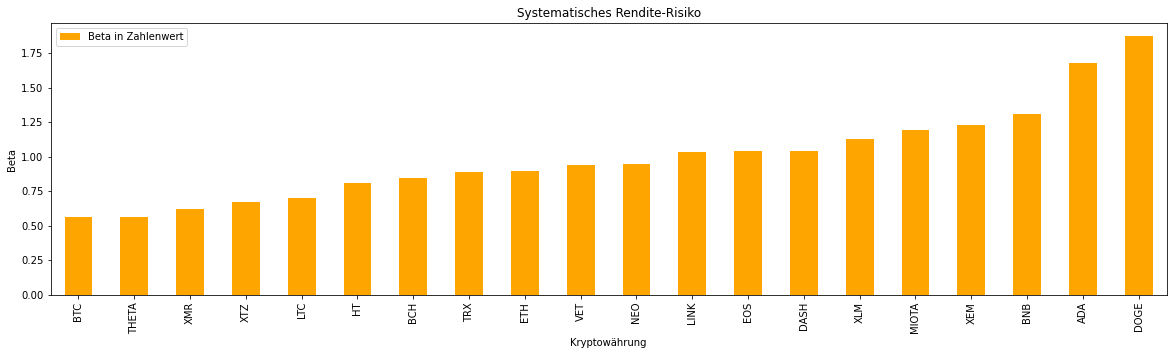

In [26]:
#m = expectedCryptoReturn_beta.iloc[1,:] <= 1.00000000000000
best_beta = expectedCryptoReturn_beta.T.sort_values(by=['beta'], ascending=True)['beta']

ax = best_beta.plot.bar(lw=2, figsize=(20,5), color='orange', title='Systematisches Rendite-Risiko')
ax.set_xlabel("Kryptowährung")
ax.set_ylabel("Beta")
ax.legend(["Beta in Zahlenwert"]);
plt.savefig('kryptoMarktRisiko.jpg')

### Beispiel: Ermittlung von Rentenendwert mit erwarteten Renditen
Wieviel würde man erhalten, wenn man 3 Jahren lang monatlich 250€ z.B. in 'ADA' investieren würde?<br>

In [27]:
crypto = 'ADA'

i = expectedCryptoReturn_beta.loc['expectedReturn', crypto].mean() #erwartete Rendite
#i = Rm #durchschn. Markrendite bzw. index
#i = 0.041 #US-Anleihe

monthly = 12 #Monate
pension = 250 #Rente
n = 3 # 3 Jahre

print('Kryptoauswahl:', crypto)
print('Einsatz mit Zinsen:', pension_calc(pension, n, monthly, i))
print('Einsatz ohne Zinsen:', n*monthly*pension)
print('Differenz:', pension_calc(pension, n, monthly, i)-(n*monthly*pension))

Kryptoauswahl: ADA
Einsatz mit Zinsen: 11100.263496434409
Einsatz ohne Zinsen: 9000
Differenz: 2100.263496434409
